In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from src.data_loader import read_data

train_data = read_data('train')
val_data = read_data('val')
test_data = read_data('test')

100%|██████████| 200/200 [00:00<00:00, 5892.03it/s]


In [3]:
import clip.clip as clip 

CLIP_MODEL,  clip_img_processor =clip.load('ViT-B/32', jit=False)

In [4]:
from src.config import BATCH_SIZE
import random 
import numpy as np 
import torch 

from src.networks.CLIP_distilBERT import CLIP_dBERT_dataset

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

def get_dataloader(data):
    dataset = CLIP_dBERT_dataset(data, clip_img_processor)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, worker_init_fn=seed_worker, generator=g)
    return data_loader
    
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)
test_loader = get_dataloader(test_data)

CLIP preprocessing: 100%|██████████| 200/200 [00:03<00:00, 66.07it/s]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:01<00:00,  1.22it/s]




For epoch = 0
Training Loss = 0.6427852728150107 | Training Accuracy = 0.007291666666666666
Validation Loss = 0.538408488035202|Validation Accuracy = 0.06350806451612903




100%|██████████| 2/2 [00:01<00:00,  1.17it/s]




For epoch = 1
Training Loss = 0.4326981780203906 | Training Accuracy = 0.10265151515151515
Validation Loss = 0.4415556639432907|Validation Accuracy = 0.10987903225806452




100%|██████████| 2/2 [00:01<00:00,  1.14it/s]




For epoch = 2
Training Loss = 0.31311674551530316 | Training Accuracy = 0.16818181818181818
Validation Loss = 0.35479284822940826|Validation Accuracy = 0.12752016129032256




100%|██████████| 2/2 [00:01<00:00,  1.11it/s]




For epoch = 3
Training Loss = 0.267937419089404 | Training Accuracy = 0.17206439393939396
Validation Loss = 0.31006045639514923|Validation Accuracy = 0.09526209677419355




100%|██████████| 2/2 [00:01<00:00,  1.09it/s]




For epoch = 4
Training Loss = 0.257559324530038 | Training Accuracy = 0.1965909090909091
Validation Loss = 0.2900000512599945|Validation Accuracy = 0.12701612903225806




100%|██████████| 2/2 [00:01<00:00,  1.09it/s]




For epoch = 5
Training Loss = 0.2617574632167816 | Training Accuracy = 0.20227272727272727
Validation Loss = 0.28156624734401703|Validation Accuracy = 0.11088709677419355




100%|██████████| 2/2 [00:01<00:00,  1.07it/s]




For epoch = 6
Training Loss = 0.2817319475791671 | Training Accuracy = 0.17850378787878787
Validation Loss = 0.2821628451347351|Validation Accuracy = 0.09475806451612903




100%|██████████| 2/2 [00:01<00:00,  1.08it/s]




For epoch = 7
Training Loss = 0.29618603126569226 | Training Accuracy = 0.18768939393939393
Validation Loss = 0.28425902128219604|Validation Accuracy = 0.14213709677419356




100%|██████████| 2/2 [00:01<00:00,  1.07it/s]




For epoch = 8
Training Loss = 0.29775646125728433 | Training Accuracy = 0.22301136363636365
Validation Loss = 0.2929472476243973|Validation Accuracy = 0.12752016129032256




100%|██████████| 2/2 [00:01<00:00,  1.07it/s]




For epoch = 9
Training Loss = 0.3047105832533403 | Training Accuracy = 0.22945075757575759
Validation Loss = 0.297971710562706|Validation Accuracy = 0.09576612903225806




100%|██████████| 2/2 [00:01<00:00,  1.06it/s]




For epoch = 10
Training Loss = 0.31011502715674316 | Training Accuracy = 0.21486742424242425
Validation Loss = 0.2975151389837265|Validation Accuracy = 0.09526209677419355




100%|██████████| 2/2 [00:01<00:00,  1.06it/s]




For epoch = 11
Training Loss = 0.30848604711619293 | Training Accuracy = 0.20473484848484846
Validation Loss = 0.3027801215648651|Validation Accuracy = 0.09425403225806452




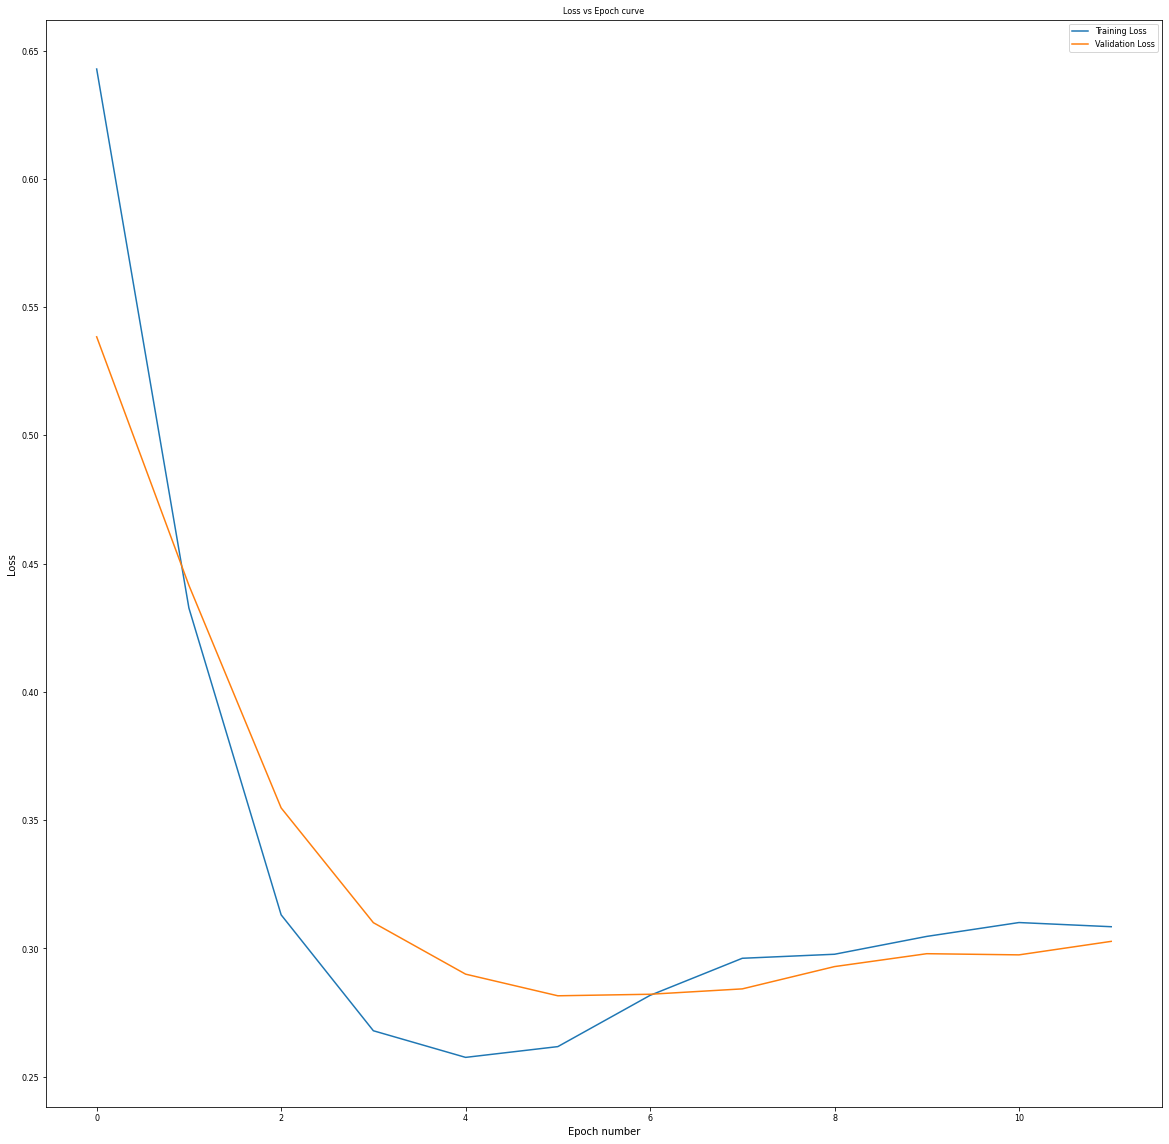

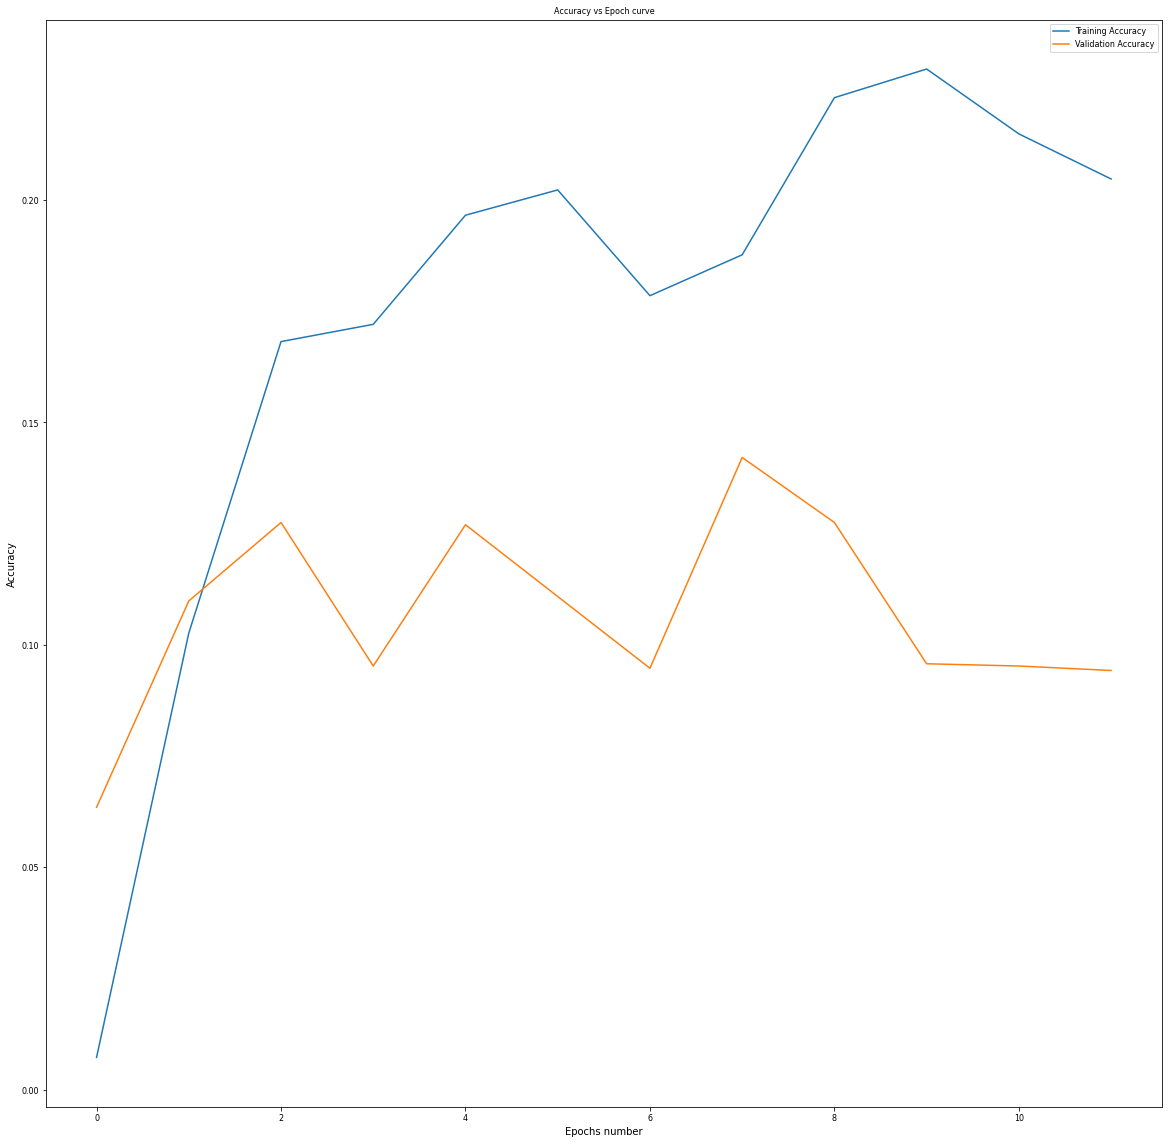

In [5]:
from src.trainer import Trainer
from src.networks.CLIP_distilBERT import CLIP_dBERT_Input_transformer, CLIP_dBERT_Model
import torch.nn as nn
import torch 

trainer = Trainer(12)

#Set data
trainer.set_data(train_loader, val_loader)

#set model 
model = CLIP_dBERT_Model(CLIP_MODEL).cuda()
input_transformer = CLIP_dBERT_Input_transformer()
trainer.set_model(model, input_transformer)

#Backpropagation
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
trainer.set_optimizer(optimizer, loss_fn)
trainer.train(l2_r=1e-3)
trainer.plot()

In [6]:
trainer.test(test_loader)

100%|██████████| 22/22 [00:20<00:00,  1.08it/s]

Accuracy Score = 28.238719068413392
Macro F1 score Score = 14.642092038288974
Micro F1 score Score = 67.5747508305648


In [7]:
torch.save(model.state_dict(), f"Models/CLIP_distilBERT.model")
